In [1]:
%load_ext autoreload
%autoreload 2

In this notebook you will learn how to get started with PytorchEO training a baseline model for the [Solar Panel Detection Using Sentinel-2](https://solafune.com/competitions/5dfc315c-1b24-4573-804f-7de8d707cd90) challenge.

## Data exploration

Before continuing, join the challenge, download and extract the [data](https://solafune.com/competitions/5dfc315c-1b24-4573-804f-7de8d707cd90?menu=data&tab=).

In [163]:
import os 
from pathlib import Path

path = Path('/fastdata/solarPanelDetection/') # path to the data 
folders = [f for f in os.listdir(path) if os.path.isdir(path / f)] # get all the folders in the path
folders

['evaluation', 'train', 'sample']

The train folder contains images and masks for training

In [164]:
os.listdir(path / 'train') 

['s2_image', 'mask']

In [165]:
from glob import glob

images = glob(str(path / 'train' / 's2_image/*.tif'))
masks = glob(str(path / 'train' / 'mask/*.tif'))

len(images), len(masks)

(2066, 2066)

In [166]:
images[:3], masks[:3]

(['/fastdata/solarPanelDetection/train/s2_image/train_s2_image_2037.tif',
  '/fastdata/solarPanelDetection/train/s2_image/train_s2_image_792.tif',
  '/fastdata/solarPanelDetection/train/s2_image/train_s2_image_1118.tif'],
 ['/fastdata/solarPanelDetection/train/mask/train_mask_539.tif',
  '/fastdata/solarPanelDetection/train/mask/train_mask_801.tif',
  '/fastdata/solarPanelDetection/train/mask/train_mask_157.tif'])

In [167]:
# generate list of image ids 

ids = [f.split('_')[-1][:-4] for f in images]
len(ids), ids[:3]

(2066, ['2037', '792', '1118'])

In [168]:
for id in ids:
	assert str(path / 'train' / 's2_image' / f'train_s2_image_{id}.tif') in images, f'train_s2_image_{id}.tif not found'
	assert str(path / 'train' / 'mask' / f'train_mask_{id}.tif') in masks, f'train_mask_{id}.tif not found'

We can visualize some samples

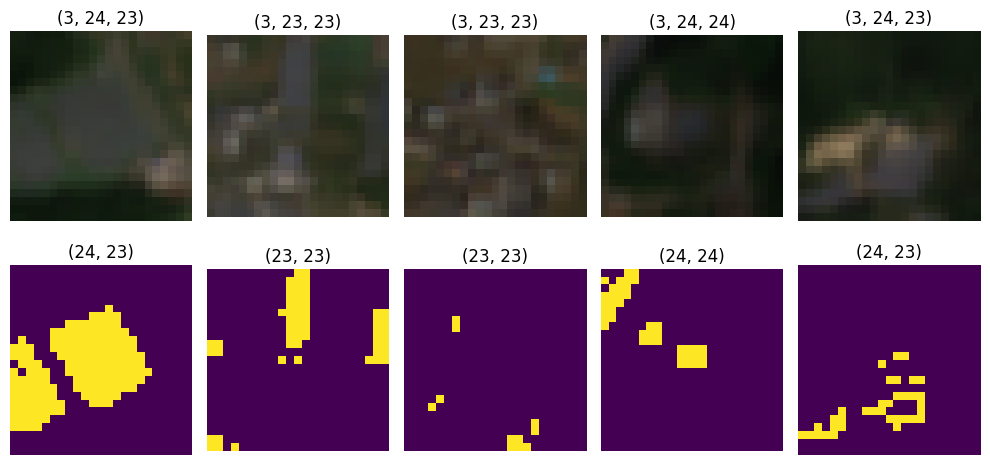

In [213]:
import matplotlib.pyplot as plt
import rasterio as rio 
import random

cols = 5
fig = plt.figure(figsize=(cols*2, 5))
for col in range(cols):
	image_id = random.choice(ids)
	ax1 = fig.add_subplot(2, cols, col+1)
	image_path = path / 'train' / 's2_image' / f'train_s2_image_{image_id}.tif'
	ds = rio.open(image_path)
	rgb = ds.read((4,3,2)) / 4000 
	ax1.imshow(rgb.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(rgb.shape)
	ax2 = fig.add_subplot(2, cols, col+cols+1)
	mask_path = path / 'train' / 'mask' / f'train_mask_{image_id}.tif'
	mask = rio.open(mask_path).read(1)
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
plt.tight_layout()
plt.show()

Images are very small and can have different size. Masks are binary.

In [9]:
rgb.dtype, mask.dtype, mask.min(), mask.max()

(dtype('float64'), dtype('uint8'), 0, 1)

In [16]:
shapes = {}
for image in images:
	x = rio.open(image).read().shape
	shapes[x] = shapes.get(x, 0) + 1
shapes

/home/juan/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{(12, 23, 24): 283,
 (12, 23, 23): 914,
 (12, 25, 25): 72,
 (12, 24, 24): 359,
 (12, 24, 23): 339,
 (12, 22, 22): 4,
 (12, 23, 22): 26,
 (12, 25, 24): 27,
 (12, 22, 23): 20,
 (12, 24, 25): 16,
 (12, 26, 25): 2,
 (12, 25, 26): 3,
 (12, 26, 26): 1}

The evaluation folder contains the images for generating the submission masks (which an examples is shown in the samples folder).

In [38]:
test_images = os.listdir(path / 'evaluation')
len(test_images), test_images[:3]

(2066,
 ['evaluation_s2_image_851.tif',
  'evaluation_s2_image_1695.tif',
  'evaluation_s2_image_1204.tif'])

In [39]:
test_masks = os.listdir(path / 'sample')
len(test_masks), test_masks[:3]

(2066,
 ['evaluation_mask_1646.tif',
  'evaluation_mask_859.tif',
  'evaluation_mask_1261.tif'])

In [40]:
test_ids = [f.split('_')[-1][:-4] for f in test_images]
assert len(test_ids) == len(test_images), 'number of test images and test ids do not match'

In [42]:
for test_id in test_ids:
	assert f'evaluation_s2_image_{test_id}.tif' in test_images, f'evaluation_s2_image_{test_id}.tif not found'
	assert f'evaluation_mask_{test_id}.tif' in test_masks, f'evaluation_mask_{test_id}.tif not found'

## The Dataset

PytorchEO is built around `Datasets` and `Tasks`. In this challenge we are asked to solve an image segmentation task with a dataset composed of Sentinel 2 images with corresponding solar panels masks. 

You can build your own PytorchEO Datasets as follows:


In [238]:
# imports
import lightning as L
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
from einops import rearrange
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from glob import glob
import os

# Pytorch EO imports
from pytorch_eo.datasets import ConcatDataset
from pytorch_eo.datasets.sensors import S2
from pytorch_eo.datasets.sensors import Sensors
from pytorch_eo.datasets import SensorImageDataset, RGBImageDataset

class Dataset(L.LightningDataModule): 

    def __init__(self,
                 batch_size=32,
                 path='/fastdata/solarPanelDetection/', 
                 val_size=0.2,
                 train_trans=None,
                 val_trans=None,
                 num_workers=0,
                 pin_memory=False,
                 seed=42,
                 verbose=False,
                 bands=None,
                 ):
        super().__init__()
        self.path = Path(path)
        self.batch_size = batch_size
        self.val_size = val_size
        self.train_trans = (
            train_trans if train_trans is not None else self.setup_trans(train_trans)
        )
        self.val_trans = (
            val_trans if val_trans is not None else self.setup_trans(val_trans)
        )
        self.bands = bands if bands is not None else S2.RGB
        self.num_bands = (
            len(self.bands)
            if isinstance(self.bands, list)
            else len(self.bands.value)
            if isinstance(self.bands.value, list)
            else 1
        )
        self.num_classes = 2
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.seed = seed
        self.verbose = verbose

    def setup(self, stage=None):
        images = glob(str(self.path / 'train' / 's2_image/*.tif'))
        ids = [f.split('_')[-1][:-4] for f in images]
        masks = [str(self.path / 'train' / 'mask' / f'train_mask_{id}.tif') for id in ids]
        _masks = glob(str(self.path / 'train' / 'mask/*.tif'))
        assert len(images) == len(masks) == len(_masks) == len(ids) == 2066, 'number of training images and masks must be 2066'
        for mask in masks:
            assert mask in _masks, f'{mask} not found'
        test_images = os.listdir(self.path / 'evaluation')
        test_ids = [f.split('_')[-1][:-4] for f in test_images]
        assert len(test_images) == len(test_ids) == 2066, 'number of test images must be 100'
        for test_id in test_ids:
            assert f'evaluation_s2_image_{test_id}.tif' in test_images, f'evaluation_s2_image_{test_id}.tif not found'
        # build dataframe and splits
        self.df = pd.DataFrame({'image': images, 'mask': masks})
        self.train_df, self.val_df = self.df, None
        if self.val_size > 0:
            self.train_df, self.val_df = train_test_split(
                self.df,
                test_size=int(len(self.df) * self.val_size),
                random_state=self.seed,
            )
        if self.verbose:
            print("Training samples", len(self.train_df))
            if self.val_df is not None:
                print("Validation samples", len(self.val_df))
        # generate datasets
        self.train_ds = self.get_dataset(self.train_df, self.train_trans)
        self.val_ds = (
            self.get_dataset(self.val_df, self.val_trans)
            if self.val_df is not None
            else None
        )
        
    def get_dataset(self, df, trans=None):
        return ConcatDataset({
            'image': SensorImageDataset(df.image.values, Sensors.S2, self.bands),
            'mask': RGBImageDataset(df['mask'].values)
        }, trans)
    
    def get_dataloader(self, ds, batch_size=None, shuffle=False):
        return DataLoader(
            ds,
            batch_size=self.batch_size if batch_size is None else batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=shuffle,
        )

    def train_dataloader(self, batch_size=None, shuffle=True):
        return self.get_dataloader(self.train_ds, batch_size, shuffle)

    def val_dataloader(self, batch_size=None, shuffle=False):
        return (
            self.get_dataloader(self.val_ds, batch_size, shuffle)
            if self.val_ds is not None
            else None
        )
    
    def setup_trans(self, trans):
        if trans is None:
            def clip(x, **kwargs):
                x = np.clip(x, 0.0, 1.0)
                return x.astype(np.float32) if x.ndim == 3 else x.astype(np.uint8)
            def normalize(x, **kwargs):
                return x / 4000 if x.ndim == 3 else (x > 0.5).astype(np.uint8)
            return (
                A.Compose(
                    [
                        A.Resize(32, 32), # resize to 32x32 due to model architecture
                        A.Lambda(image=normalize), 
                        A.Lambda(image=clip), 
                        ToTensorV2(),  
                    ],
                additional_targets={"mask": "image"}, is_check_shapes=False) # original images and masks can have different shapes
                if trans is None
                else trans
            )
        return trans


In [239]:
ds = Dataset(batch_size=5)
ds.setup()

In [240]:
ds.df

,image,mask
0,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
1,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
3,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
4,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
...,...,...
2061,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2062,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2063,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...
2064,/fastdata/solarPanelDetection/train/s2_image/t...,/fastdata/solarPanelDetection/train/mask/train...


In [241]:
batch = next(iter(ds.train_dataloader()))

images, masks = batch['image'], batch['mask']
images.shape, masks.shape, images.dtype, masks.dtype, images.max(), masks.max(), images.min(), masks.min()

/home/juan/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(torch.Size([5, 3, 32, 32]),
 torch.Size([5, 1, 32, 32]),
 torch.float32,
 torch.uint8,
 tensor(0.4989),
 tensor(1, dtype=torch.uint8),
 tensor(0.0475),
 tensor(0, dtype=torch.uint8))

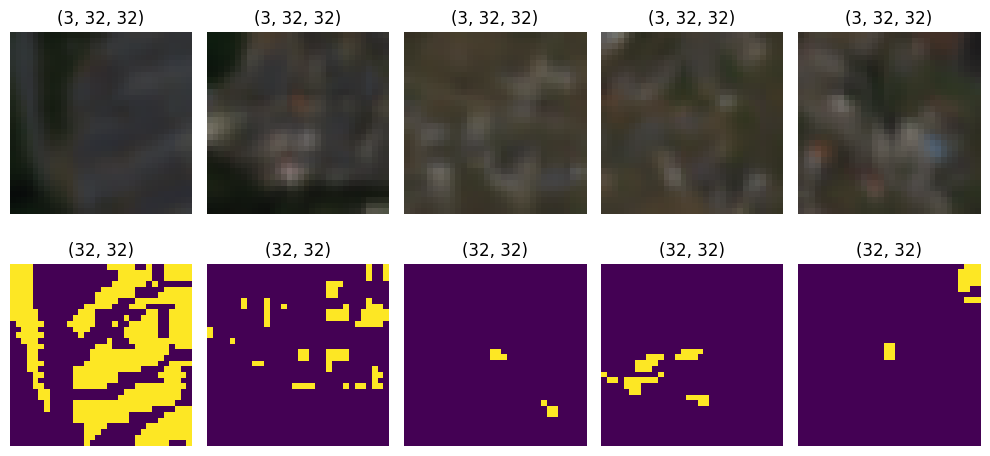

In [242]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
images, masks = batch['image'], batch['mask']
cols = 5
fig = plt.figure(figsize=(cols*2, 5))
for col in range(cols):
	ax1 = fig.add_subplot(2, cols, col+1)
	image = images[col].numpy()
	ax1.imshow(image.transpose(1,2,0))
	ax1.axis('off')
	ax1.set_title(image.shape)
	ax2 = fig.add_subplot(2, cols, col+cols+1)
	mask = masks[col].numpy()[0]
	ax2.imshow(mask)
	ax2.axis('off')
	ax2.set_title(mask.shape)
plt.tight_layout()
plt.show()

## The Task

PytorchEO comes with several tasks built in, and more to come. In this case, we use the `ImageSegmentationTask`.

In [243]:
import torch
from pytorch_eo.tasks import ImageSegmentation

task = ImageSegmentation(num_classes=ds.num_classes)

out = task(torch.randn(32, 3, 32, 32))

out.shape, out.dtype

(torch.Size([32, 2, 32, 32]), torch.float32)

## Training

We use [PytorchLighning](https://pytorch-lightning.readthedocs.io/) for training.


In [246]:
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint

ds = Dataset()
task = ImageSegmentation(num_classes=ds.num_classes)

# overfit batches to check if model is working

trainer = pl.Trainer(
	max_epochs=30,
	overfit_batches=1,
    enable_checkpointing=False,
	logger=None,
	accelerator="cuda",
    devices=1,
	precision=16,
)

trainer.fit(task, ds)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/juan/.local/lib/python3.10/site-packages/lightning_fabric/connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
/home/juan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:565: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/juan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:684: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have alrea

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_91527/2199048492.py:9 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_91527/2199048492.py'                        │
│                                                                                                  │
│ /home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/argparse.py:69 in     │
│ insert_env_defaults                                                                              │
│                                                                                                  │
│   66 │   │   kwargs = dict(list(env_variables.items()) + list(kwargs.items()))                   │
│   67 │   │                                                                                       │
│   68 │   │   # all args were already moved to kwargs                                             │
│ ❱ 69 │   │   return fn(self, **kwargs)                                                           │
│   70 │                                                                                           │
│   71 │   return cast(_T, insert_env_defaults)                                                    │
│   72                                                                                             │
│                                                                                                  │
│ /home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:398 in       │
│ __init__                                                                                         │
│                                                                                                  │
│    395 │   │   # init connectors                                                                 │
│    396 │   │   self._data_connector = _DataConnector(self)                                       │
│    397 │   │                                                                                     │
│ ❱  398 │   │   self._accelerator_connector = _AcceleratorConnector(                              │
│    399 │   │   │   devices=devices,                                                              │
│    400 │   │   │   accelerator=accelerator,                                                      │
│    401 │   │   │   strategy=strategy,                                                            │
│                                                                                                  │
│ /home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_ │
│ connector.py:157 in __init__                                                                     │
│                                                                                                  │
│   154 │   │   │   self._accelerator_flag = self._choose_gpu_accelerator_backend()                │
│   155 │   │                                                                                      │
│   156 │   │   self._check_device_config_and_set_final_flags(devices=devices, num_nodes=num_nod   │
│ ❱ 157 │   │   self._set_parallel_devices_and_init_accelerator()                                  │
│   158 │   │                                                                                      │
│   159 │   │   # 3. Instantiate ClusterEnvironment                                                │
│   160 │   │   self.cluster_environment: ClusterEnvironment = self._choose_and_init_cluster_env   │
│                                                                                                  │
│ /home/juan/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_ │
│ connector.py:381 in _set_parallel_devices_and_init_accelera

Feel free to add your favourite callbacks, accelerators, data augmentation... The following is a more complete example.

In [ ]:
import albumentations as A 

pl.seed_everything(42, workers=True) # make results reproducible

trans = A.Compose([ # some data augmentation (we use albumentations)
	A.RandomRotate90(),
	A.HorizontalFlip(),
	A.VerticalFlip(),
])

bands = [S2.blue, S2.green, S2.red, S2.nir1] # choose any bands combination

ds = OnCloudNDataset(
    batch_size=64, # increase the batch size to fully use your GPU
    bands=bands,
    num_workers=20, # faster data loading (put here your CPU core count)
    pin_memory=True, # faster data loading
    train_trans=trans,
)

model = Model(in_chans=len(bands))

hparams = { # customize optimizer
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-3
    },
	'scheduler': 'MultiStepLR',
	'scheduler_params': {
		'milestones': [3, 6],
		'verbose': True
	} # add anything you want to save as hparams with your model
}

# customize your metrics (use as many as you want)

def iou(pr, gt, th=0.5, eps=1e-7):
        mask = gt.ne(255) # ignore value 255 in mask
        gt = gt.masked_select(mask)
        pr = pr.masked_select(mask)
        pr = torch.sigmoid(pr) > th
        gt = gt > th 
        intersection = torch.sum(gt & pr)
        union = torch.sum(gt | pr)
        return intersection / (union + eps)

metrics = {'iou': iou} 

# customize your loss function

loss_fn = smp.losses.SoftBCEWithLogitsLoss(ignore_index=255) # ignore value 255 in mask

# train the model

task = ImageSegmentation(model, hparams=hparams, metrics=metrics, loss_fn=loss_fn)

trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    precision=16,
    callbacks=[ # save best model during training
		ModelCheckpoint(
			dirpath='./',
			filename=f"unet-baseline-{{val_iou:.4f}}",
			save_top_k=1,
			monitor='val_iou',
			mode='max'
		)
	],
	deterministic=True, # make results reproducible
)

trainer.fit(task, ds)

## Submission

This is a code submission challenge, you can find an example on how to submit [here](https://www.drivendata.co/blog/cloud-cover-benchmark/). First, we have to export our model, in this case using `torchscript`. 

In [ ]:
# optionally, load from checkpoint
cpu_model = model.cpu()
sample_input_cpu = torch.randn(32, 512, 512, len(bands))
traced_cpu = torch.jit.trace(cpu_model, sample_input_cpu)
torch.jit.save(traced_cpu, "model.pt")

Finally, write a `main.py` file with the following content and compress it along with the exported model with the name `submission.zip` to submit into the challenge platform.

In [ ]:
from pathlib import Path
import os
from tifffile import imsave, imread
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

images_path = Path('/codeexecution/data/test_features')
predictions_path = Path('/codeexecution/predictions')
chip_ids = os.listdir(images_path)
bands = ['B02', 'B03', 'B04', 'B08']

class MyDataset(Dataset):
    def __init__(self, images):
        super().__init__()
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        chip_id = self.images[idx]
        img = [imread(images_path / chip_id / f'{band}.tif') for band in bands]
        img = np.stack(img, axis=-1).astype(np.float32)
        return torch.from_numpy(img), chip_id


ds = MyDataset(chip_ids)

dl = DataLoader(ds, batch_size=64, shuffle=False,
                num_workers=4, pin_memory=True)

model = torch.jit.load("model.pt")
model.cuda()
model.eval()

for batch in dl:
    imgs, chips = batch
    with torch.no_grad():
        pred = model(imgs.cuda())
    masks = torch.sigmoid(pred) > 0.5
    masks = masks.cpu().numpy().astype(np.uint8)
    for i, chip in enumerate(chips):
        imsave(predictions_path / f'{chip}.tif', masks[i, ...])



> Pytorch 1.8 is required at the moment of this writing ! This is the version used in the scoring platform and different versions may cause conflicts with `torchscript`. 

I hope you like the library, we are planning to include more datasets and tasks in the future. If you find it useful please get in touch !!!